In [10]:
#!/usr/bin/env python3
"""
UMAP plot colored by celltype and split by stage.
- Loads embeddings from 31_svd_embedding/output/decomp/total_decomp.npz (n_cells x n_features)
- Loads cell labels from 31_svd_embedding/output/decomp/cell_labels.csv if exists,
  otherwise builds it by merging code/cell_table.tsv with stage_files_mapping.csv
- Runs UMAP (n_neighbors, min_dist configurable) to 2D
- Plots with seaborn/matplotlib: color by celltype, small facets per stage
- Saves figure(s) into 31_svd_embedding/plot/output
"""
from __future__ import annotations
import argparse
import json
from pathlib import Path
from typing import Dict, Optional, Tuple

import numpy as np
import pandas as pd

# Prefer umap-learn; fallback to sklearn if needed
try:
    import umap
    UMAPImpl = 'umap-learn'
except Exception:  # pragma: no cover
    umap = None
    from sklearn.manifold import TSNE  # type: ignore
    UMAPImpl = 'sklearn-TSNE'

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors

from pathlib import Path

# 手动指定根目录路径
ROOT = Path("/Volumes/SumSung500/CSU/0_HiRES/31_svd_embedding").resolve()
DECOMP_DIR = ROOT / "output" / "decomp"
DEFAULT_EMBED_PATH = DECOMP_DIR / "total_decomp.npz"
LABELS_PATH = DECOMP_DIR / "cell_labels.csv"
CELL_TABLE_PATH = ROOT / "code" / "cell_table.tsv"
STAGE_MAP_PATH = Path(ROOT).parents[1] / "stage_files_mapping.csv"
COLOR_MAP_JSON = Path(ROOT).parents[1] / "5_plot_umap" / "color_mapping.json"
PLOT_OUT_DIR = ROOT / "plot" / "output"


def ensure_labels(labels_csv: Path = LABELS_PATH) -> pd.DataFrame:
    labels_csv.parent.mkdir(parents=True, exist_ok=True)
    if labels_csv.exists():
        df = pd.read_csv(labels_csv)
        needed = {"cell_id", "cellname", "stage", "celltype"}
        if needed.issubset(df.columns):
            return df
        # else rebuild
    # Build labels from sources
    cell_tbl = pd.read_csv(CELL_TABLE_PATH, sep='\t', header=None, names=["cell_id", "extra"], dtype=str)
    if "cell_id" not in cell_tbl.columns:
        raise RuntimeError(f"Unexpected cell_table format at {CELL_TABLE_PATH}")
    cell_tbl["cellname"] = cell_tbl["cell_id"]

    if not STAGE_MAP_PATH.exists():
        raise FileNotFoundError(f"Missing stage mapping CSV at {STAGE_MAP_PATH}")
    stage_map = pd.read_csv(STAGE_MAP_PATH)
    if "cellname" not in stage_map.columns:
        raise RuntimeError("stage_files_mapping.csv must contain 'cellname' column")

    merged = cell_tbl.merge(stage_map[["cellname", "stage", "celltype"]], on="cellname", how="left")
    missing = merged["celltype"].isna().sum()
    if missing > 0:
        print(f"[warn] {missing} rows missing celltype after merge; filling as 'unknown'")
        merged["celltype"].fillna("unknown", inplace=True)
    merged.to_csv(labels_csv, index=False)
    return merged


def load_embeddings(npz_path: Path = DEFAULT_EMBED_PATH) -> np.ndarray:
    if not npz_path.exists():
        raise FileNotFoundError(f"Embedding file not found: {npz_path}")
    with np.load(npz_path) as data:
        # Accept 'arr_0' or 'X' style keys
        key = 'arr_0'
        if 'X' in data.files:
            key = 'X'
        X = data[key]
    if X.ndim != 2:
        raise ValueError(f"Expected 2D array, got shape {X.shape}")
    return X


def load_color_map() -> Dict[str, str]:
    # Try external color mapping first
    if COLOR_MAP_JSON.exists():
        try:
            with open(COLOR_MAP_JSON, 'r') as f:
                cmap = json.load(f)
            # some files store nested dict; flatten if necessary
            if isinstance(cmap, dict) and all(isinstance(v, str) for v in cmap.values()):
                return cmap  # simple mapping
            if isinstance(cmap, dict) and 'celltype' in cmap:
                return cmap['celltype']
        except Exception as e:
            print(f"[warn] Failed to read color mapping: {e}")
    # Default palette generator
    return {}


def get_palette(categories: pd.Index, pref_map: Dict[str, str]) -> Dict[str, str]:
    cats = list(categories)
    # Use preferred mapping where provided
    unmapped = [c for c in cats if c not in pref_map]
    palette = {}
    if len(unmapped) > 0:
        colors = sns.color_palette("tab20", n_colors=max(20, len(unmapped)))
        for c, col in zip(unmapped, colors):
            # col is an RGB tuple in 0..1; convert to hex via matplotlib
            palette[c] = mcolors.to_hex(col)
    # Merge explicit prefs last to override
    palette.update(pref_map)
    return palette


def compute_2d(X: np.ndarray, n_neighbors: int, min_dist: float, random_state: int = 42) -> np.ndarray:
    if umap is not None:
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=random_state)
        coords = reducer.fit_transform(X)
    else:
        print("[info] umap-learn not available; falling back to sklearn TSNE")
        tsne = TSNE(n_components=2, random_state=random_state, init='pca', learning_rate='auto')
        coords = tsne.fit_transform(X)
    return coords


def plot_umap_split_by_stage(
    coords: np.ndarray,
    labels: pd.DataFrame,
    color_by: str = "celltype",
    split_by: str = "stage",
    point_size: float = 6.0,
    alpha: float = 0.9,
    figsize: Tuple[int, int] = (14, 4),
    out_png: Optional[Path] = None,
    out_pdf: Optional[Path] = None,
    color_map: Optional[Dict[str, str]] = None,
):
    df = labels.copy().reset_index(drop=True)
    df["UMAP1"], df["UMAP2"] = coords[:, 0], coords[:, 1]

    # Order stages naturally if possible
    stages = sorted(df[split_by].dropna().unique().tolist())
    n_stage = len(stages)
    # force single row layout
    nrows, ncols = 1, max(1, n_stage)
    # adjust figsize dynamically to keep each panel readable
    panel_w = max(3.0, min(5.0, figsize[0] / max(1, ncols)))
    figsize = (panel_w * ncols, figsize[1])

    # Setup color palette
    if color_map is None:
        color_map = {}
    palette = get_palette(df[color_by].astype(str).unique(), color_map)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    axes = axes.flatten()

    for i, stage in enumerate(stages):
        ax = axes[i]
        sub = df[df[split_by] == stage]
        for ct, sub2 in sub.groupby(color_by):
            ax.scatter(sub2["UMAP1"], sub2["UMAP2"], s=point_size, alpha=alpha, c=palette.get(str(ct), "#888888"), label=str(ct))
        ax.set_title(f"{split_by}: {stage} (n={len(sub)})", fontsize=10)
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")
        ax.tick_params(labelleft=False, labelbottom=False)
        # no per-axes legend; collect globally

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Build a single global legend from the full dataframe
    # Use palette keys order for consistent legend order
    legend_labels = list(palette.keys())
    legend_colors = [palette[k] for k in legend_labels]
    from matplotlib.lines import Line2D
    handles = [Line2D([0], [0], marker='o', color='none', label=lab, markerfacecolor=col, markersize=6)
               for lab, col in zip(legend_labels, legend_colors)]

    # place legend to the right of the last subplot
    fig.legend(handles=handles, labels=legend_labels,
               loc='center right', bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=8)

    plt.tight_layout(rect=[0, 0, 0.98, 1])

    if out_png:
        fig.savefig(out_png, dpi=300)
    if out_pdf:
        fig.savefig(out_pdf)
    plt.close(fig)


def main():
    parser = argparse.ArgumentParser(description="UMAP colored by celltype and split by stage")
    parser.add_argument("--embedding", type=str, default=str(DEFAULT_EMBED_PATH), help="Path to NPZ embedding (default: total_decomp.npz)")
    parser.add_argument("--n_neighbors", type=int, default=15)
    parser.add_argument("--min_dist", type=float, default=0.1)
    parser.add_argument("--out_prefix", type=str, default=str(PLOT_OUT_DIR / "umap_celltype_split_stage"))
    parser.add_argument("--point_size", type=float, default=6.0)
    parser.add_argument("--alpha", type=float, default=0.9)
    # In notebooks, Jupyter injects its own argv; ignore unknowns
    args = parser.parse_known_args()[0]

    PLOT_OUT_DIR.mkdir(parents=True, exist_ok=True)

    # Load data
    labels = ensure_labels(LABELS_PATH)
    X = load_embeddings(Path(args.embedding))
    if len(labels) != X.shape[0]:
        raise ValueError(f"Row count mismatch: labels {len(labels)} vs embedding {X.shape[0]}")

    # Compute 2D
    coords = compute_2d(X, n_neighbors=args.n_neighbors, min_dist=args.min_dist)

    # Colors
    pref_colors = load_color_map()

    # Plot
    out_png = Path(args.out_prefix).with_suffix('.png')
    out_pdf = Path(args.out_prefix).with_suffix('.pdf')
    plot_umap_split_by_stage(coords, labels, color_by="celltype", split_by="stage", point_size=args.point_size, alpha=args.alpha, out_png=out_png, out_pdf=out_pdf, color_map=pref_colors)

    # Also save a CSV with coordinates for reproducibility
    out_csv = Path(args.out_prefix).with_suffix('.csv')
    out_df = labels.copy()
    out_df["UMAP1"], out_df["UMAP2"] = coords[:, 0], coords[:, 1]
    out_df.to_csv(out_csv, index=False)
    print(f"Saved: {out_png}\nSaved: {out_pdf}\nSaved: {out_csv}")


if __name__ == "__main__":
    main()


/Users/wuhaoliu/mamba/envs/schicluster/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Saved: /Volumes/SumSung500/CSU/0_HiRES/31_svd_embedding/plot/output/umap_celltype_split_stage.png
Saved: /Volumes/SumSung500/CSU/0_HiRES/31_svd_embedding/plot/output/umap_celltype_split_stage.pdf
Saved: /Volumes/SumSung500/CSU/0_HiRES/31_svd_embedding/plot/output/umap_celltype_split_stage.csv


Loading data...
Computing 2D embedding using umap-learn...


/Users/wuhaoliu/mamba/envs/schicluster/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/wuhaoliu/mamba/envs/schicluster/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Computation complete.
Generating plot...


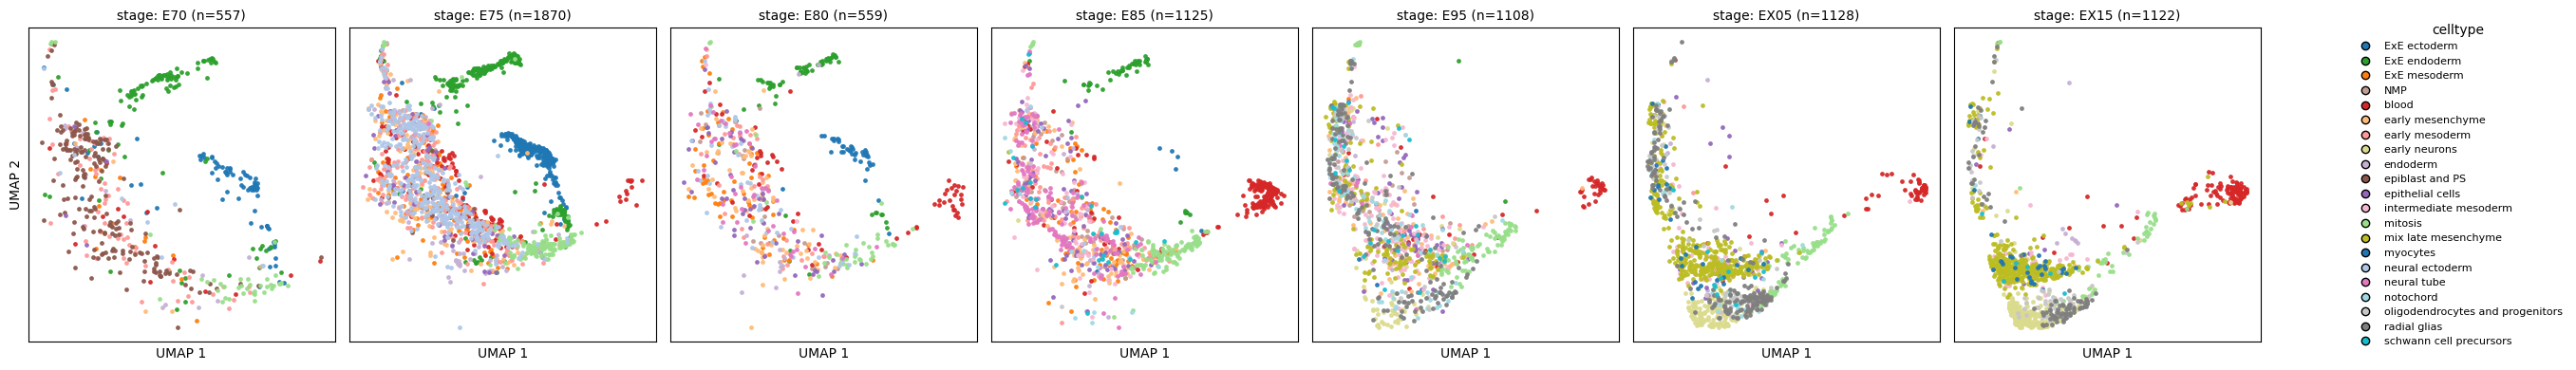

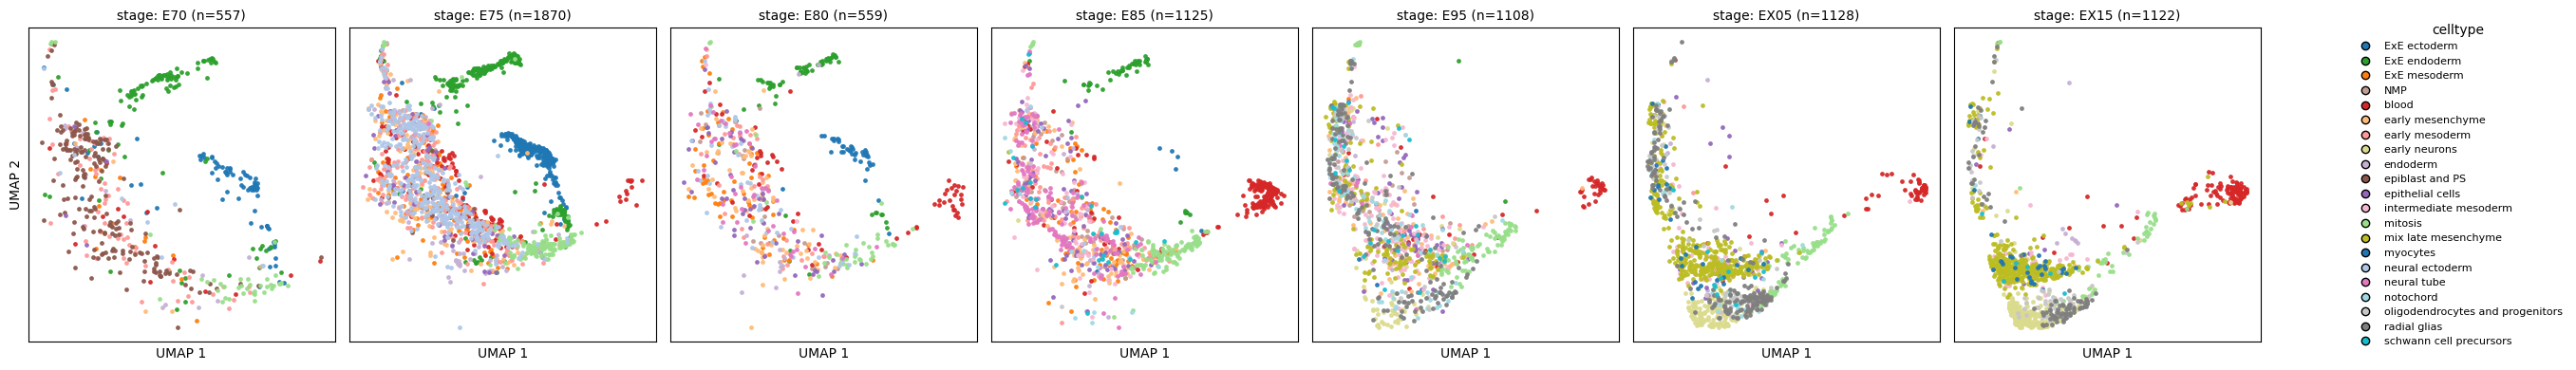

In [1]:
#!/usr/bin/env python3
"""
UMAP plot colored by celltype and split by stage.
This script is adapted for execution in a Jupyter Notebook.
"""
# -----------------------------------------------------------------------------
# CELL 1: Imports
# -----------------------------------------------------------------------------
from __future__ import annotations
import json
from pathlib import Path
from typing import Dict, Optional, Tuple

import numpy as np
import pandas as pd

# Prefer umap-learn; fallback to sklearn if needed
try:
    import umap
    UMAPImpl = 'umap-learn'
except ImportError:  # pragma: no cover
    umap = None
    from sklearn.manifold import TSNE  # type: ignore
    UMAPImpl = 'sklearn-TSNE'
    print("[info] umap-learn not found. Falling back to sklearn.manifold.TSNE.")
    print("[info] To install umap-learn, run: pip install umap-learn")


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from pathlib import Path

# -----------------------------------------------------------------------------
# CELL 2: Configuration and Parameters
# All settings that were previously command-line arguments are defined here.
# -----------------------------------------------------------------------------

# --- Paths ---
# Manually specify the root directory for your project
ROOT = Path("/Volumes/SumSung500/CSU/0_HiRES/31_svd_embedding").resolve()
DECOMP_DIR = ROOT / "output" / "decomp"
PLOT_OUT_DIR = ROOT / "plot" / "output"

# Input files
DEFAULT_EMBED_PATH = DECOMP_DIR / "total_decomp.npz"
LABELS_PATH = DECOMP_DIR / "cell_labels.csv"
CELL_TABLE_PATH = ROOT / "code" / "cell_table.tsv"
STAGE_MAP_PATH = Path(ROOT).parents[1] / "stage_files_mapping.csv"
COLOR_MAP_JSON = Path(ROOT).parents[1] / "5_plot_umap" / "color_mapping.json"

# --- UMAP/t-SNE Parameters ---
embedding_path = DEFAULT_EMBED_PATH
n_neighbors = 15
min_dist = 0.1

# --- Plotting Parameters ---
out_prefix = PLOT_OUT_DIR / "umap_celltype_split_stage"
point_size = 6.0
alpha = 0.9

# -----------------------------------------------------------------------------
# CELL 3: Helper Functions
# -----------------------------------------------------------------------------

def ensure_labels(labels_csv: Path = LABELS_PATH) -> pd.DataFrame:
    """Loads cell labels from CSV, or builds it from source files if it doesn't exist."""
    labels_csv.parent.mkdir(parents=True, exist_ok=True)
    if labels_csv.exists():
        df = pd.read_csv(labels_csv)
        needed = {"cell_id", "cellname", "stage", "celltype"}
        if needed.issubset(df.columns):
            return df
        # else rebuild if columns are missing

    print(f"'{labels_csv.name}' not found or is malformed. Rebuilding from source files...")
    # Build labels from sources
    cell_tbl = pd.read_csv(CELL_TABLE_PATH, sep='\t', header=None, names=["cell_id", "extra"], dtype=str)
    if "cell_id" not in cell_tbl.columns:
        raise RuntimeError(f"Unexpected cell_table format at {CELL_TABLE_PATH}")
    cell_tbl["cellname"] = cell_tbl["cell_id"]

    if not STAGE_MAP_PATH.exists():
        raise FileNotFoundError(f"Missing stage mapping CSV at {STAGE_MAP_PATH}")
    stage_map = pd.read_csv(STAGE_MAP_PATH)
    if "cellname" not in stage_map.columns:
        raise RuntimeError("stage_files_mapping.csv must contain 'cellname' column")

    merged = cell_tbl.merge(stage_map[["cellname", "stage", "celltype"]], on="cellname", how="left")
    missing = merged["celltype"].isna().sum()
    if missing > 0:
        print(f"[warn] {missing} rows missing celltype after merge; filling as 'unknown'")
        merged["celltype"].fillna("unknown", inplace=True)
    merged.to_csv(labels_csv, index=False)
    print(f"Labels successfully built and saved to '{labels_csv.name}'")
    return merged


def load_embeddings(npz_path: Path = DEFAULT_EMBED_PATH) -> np.ndarray:
    """Loads the embedding matrix from an .npz file."""
    if not npz_path.exists():
        raise FileNotFoundError(f"Embedding file not found: {npz_path}")
    with np.load(npz_path) as data:
        # Accept 'arr_0' or 'X' style keys for flexibility
        key = 'X' if 'X' in data.files else 'arr_0'
        X = data[key]
    if X.ndim != 2:
        raise ValueError(f"Expected 2D array, got shape {X.shape}")
    return X


def load_color_map() -> Dict[str, str]:
    """Loads a preferred color mapping from a JSON file if it exists."""
    if COLOR_MAP_JSON.exists():
        try:
            with open(COLOR_MAP_JSON, 'r') as f:
                cmap = json.load(f)
            # Handle nested dictionary format
            if isinstance(cmap, dict) and 'celltype' in cmap and isinstance(cmap['celltype'], dict):
                return cmap['celltype']
            if isinstance(cmap, dict) and all(isinstance(v, str) for v in cmap.values()):
                return cmap  # Simple mapping
        except Exception as e:
            print(f"[warn] Failed to read or parse color mapping JSON: {e}")
    return {} # Return empty dict if file doesn't exist or fails


def get_palette(categories: pd.Index, pref_map: Dict[str, str]) -> Dict[str, str]:
    """Generates a color palette, using a preferred map for specified categories."""
    cats = list(categories)
    palette = {}
    # Apply preferred mapping first
    palette.update(pref_map)
    # Generate colors for any remaining categories
    unmapped = [c for c in cats if c not in palette]
    if len(unmapped) > 0:
        # Use a well-distinguishable color palette
        colors = sns.color_palette("tab20", n_colors=max(20, len(unmapped)))
        for c, col in zip(unmapped, colors):
            palette[c] = mcolors.to_hex(col)
    return palette


def compute_2d(X: np.ndarray, n_neighbors: int, min_dist: float, random_state: int = 42) -> np.ndarray:
    """Computes 2D coordinates using UMAP or falls back to t-SNE."""
    print(f"Computing 2D embedding using {UMAPImpl}...")
    if umap is not None:
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=random_state)
        coords = reducer.fit_transform(X)
    else:
        # Fallback to t-SNE if umap-learn is not installed
        tsne = TSNE(n_components=2, random_state=random_state, init='pca', learning_rate='auto', perplexity=min(30, X.shape[0]-1))
        coords = tsne.fit_transform(X)
    print("Computation complete.")
    return coords


def plot_umap_split_by_stage(
    coords: np.ndarray,
    labels: pd.DataFrame,
    color_by: str = "celltype",
    split_by: str = "stage",
    point_size: float = 6.0,
    alpha: float = 0.9,
    figsize: Tuple[int, int] = (14, 4),
    color_map: Optional[Dict[str, str]] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """Plots the UMAP, faceted by stage, and returns the figure object."""
    df = labels.copy().reset_index(drop=True)
    df["DIM1"], df["DIM2"] = coords[:, 0], coords[:, 1]
    dim_prefix = "UMAP" if UMAPImpl == 'umap-learn' else "t-SNE"

    stages = sorted(df[split_by].dropna().unique().tolist())
    n_stage = len(stages)
    nrows, ncols = 1, max(1, n_stage)
    panel_w = max(3.5, min(5.0, figsize[0] / max(1, ncols)))
    figsize = (panel_w * ncols, figsize[1])

    if color_map is None:
        color_map = {}
    palette = get_palette(df[color_by].astype(str).unique(), color_map)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    axes = axes.flatten()

    for i, stage in enumerate(stages):
        ax = axes[i]
        sub = df[df[split_by] == stage]
        for ct, sub2 in sub.groupby(color_by):
            ax.scatter(sub2["DIM1"], sub2["DIM2"], s=point_size, alpha=alpha, c=palette.get(str(ct), "#888888"), label=str(ct))
        ax.set_title(f"{split_by}: {stage} (n={len(sub)})", fontsize=10)
        ax.set_xlabel(f"{dim_prefix} 1")
        if i == 0:
            ax.set_ylabel(f"{dim_prefix} 2")
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Create a single global legend
    from matplotlib.lines import Line2D
    handles = [Line2D([0], [0], marker='o', color='none', label=lab, markerfacecolor=col, markersize=6)
               for lab, col in sorted(palette.items())] # Sort for consistent order

    fig.legend(handles=handles, title=color_by,
               loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize=8)

    plt.tight_layout(rect=[0, 0, 0.98, 1])

    return fig, axes


# -----------------------------------------------------------------------------
# CELL 4: Main Execution Block
# -----------------------------------------------------------------------------

# Ensure the output directory exists
PLOT_OUT_DIR.mkdir(parents=True, exist_ok=True)

# 1. Load data
print("Loading data...")
labels_df = ensure_labels(LABELS_PATH)
embedding_matrix = load_embeddings(embedding_path)

if len(labels_df) != embedding_matrix.shape[0]:
    raise ValueError(f"Row count mismatch: labels {len(labels_df)} vs embedding {embedding_matrix.shape[0]}")

# 2. Compute 2D coordinates
coordinates = compute_2d(embedding_matrix, n_neighbors=n_neighbors, min_dist=min_dist)

# 3. Load preferred colors
preferred_colors = load_color_map()

# 4. Plot the results
print("Generating plot...")
fig, _ = plot_umap_split_by_stage(
    coordinates,
    labels_df,
    color_by="celltype",
    split_by="stage",
    point_size=point_size,
    alpha=alpha,
    color_map=preferred_colors
)

# 5. Save the output files
# out_png = Path(out_prefix).with_suffix('.png')
# out_pdf = Path(out_prefix).with_suffix('.pdf')
# out_csv = Path(out_prefix).with_suffix('.csv')

# fig.savefig(out_png, dpi=300, bbox_inches='tight')
# fig.savefig(out_pdf, bbox_inches='tight')

# out_df = labels_df.copy()
# dim_prefix = "UMAP" if UMAPImpl == 'umap-learn' else "tSNE"
# out_df[f"{dim_prefix}1"] = coordinates[:, 0]
# out_df[f"{dim_prefix}2"] = coordinates[:, 1]
# out_df.to_csv(out_csv, index=False)

# print(f"\nOutputs successfully saved:")
# print(f"  - Plot (PNG): {out_png}")
# print(f"  - Plot (PDF): {out_pdf}")
# print(f"  - Coordinates (CSV): {out_csv}")

# 6. Display the plot directly in the notebook output
# In a Jupyter cell, having the figure object as the last line will render it.
fig


Computing neighbors and UMAP embedding...
Stages: ['E70', 'E75', 'E80', 'E85', 'E95', 'EX05', 'EX15']
Cell types: 21 unique types


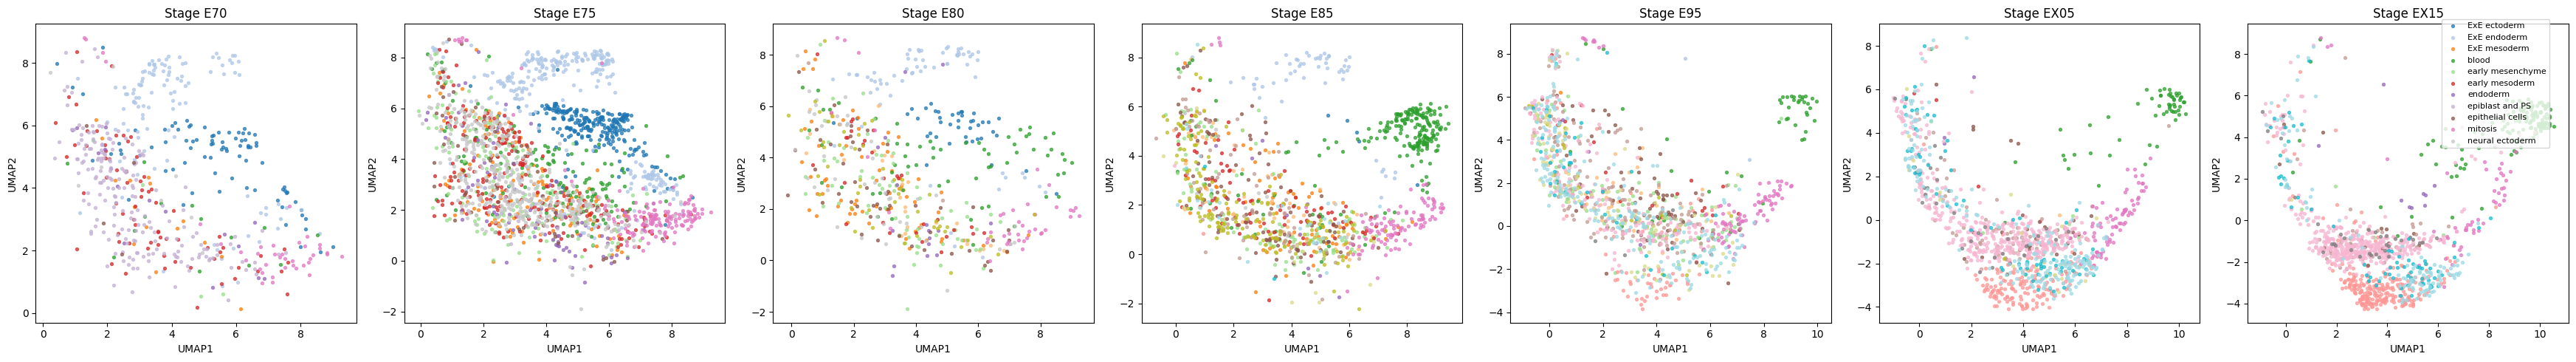

In [2]:
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the h5ad file
adata = sc.read_h5ad('/Volumes/SumSung500/CSU/0_HiRES/31_svd_embedding/output/decomp/embedding_data.h5ad')

# Compute neighbors and UMAP embedding if not already computed
if 'X_umap' not in adata.obsm:
    print("Computing neighbors and UMAP embedding...")
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
    sc.tl.umap(adata)

# Get unique stages and cell types
stages = sorted(adata.obs['stage'].unique())
cell_types = sorted(adata.obs['celltype'].unique())
print(f"Stages: {stages}")
print(f"Cell types: {len(cell_types)} unique types")

# Create a color map for cell types
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
colors = cm.tab20(np.linspace(0, 1, len(cell_types)))
cell_type_colors = dict(zip(cell_types, colors))

# Create UMAP plots for each stage, colored by cell type
fig, axes = plt.subplots(1, len(stages), figsize=(5*len(stages), 5))
if len(stages) == 1:
    axes = [axes]
elif len(stages) == 0:
    print("No stages found in data")
    exit()

# Plot for each stage
for i, stage in enumerate(stages):
    # Create a mask for the current stage
    mask = adata.obs['stage'] == stage

    # Plot each cell type with its specific color
    for cell_type in cell_types:
        cell_mask = (adata.obs['stage'] == stage) & (adata.obs['celltype'] == cell_type)
        if np.sum(cell_mask) > 0:  # Only plot if there are cells of this type
            axes[i].scatter(
                adata.obsm['X_umap'][cell_mask, 0],
                adata.obsm['X_umap'][cell_mask, 1],
                c=[cell_type_colors[cell_type]],
                s=8, alpha=0.7, label=cell_type
            )

    axes[i].set_title(f'Stage {stage}')
    axes[i].set_xlabel('UMAP1')
    axes[i].set_ylabel('UMAP2')

# Add legend to the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.99, 0.95), fontsize=8)

plt.tight_layout()
# output_path = '/home/duxuyan/Projects/schicluster_mac/31_svd_embedding/output/decomp/stage_umap_subplots_by_celltype.png'
# plt.savefig(output_path, dpi=300, bbox_inches='tight')
# print(f"Stage-based UMAP subplots colored by cell type saved to: {output_path}")
plt.show()